In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


In [4]:
file_path = "words_new.txt"
with open(file_path) as f:
    lines = f.readlines()

label_raw = lines[18:]  # Skipping the initial lines that are comments

image_texts = []
image_paths = []
default_path = "iam_words/words/"
for label in label_raw:
    parts = label.strip().split()  # Using strip() to remove any leading/trailing whitespaces
    if len(parts) < 9:  # Check if the line has fewer parts than expected
        print(f"Skipping line due to unexpected format: {label}")
        continue  # Skip this iteration and move to the next line
    if parts[1] == "ok":
        image_texts.append(parts[-1])
        image_id = parts[0]
        subdir1 = image_id.split("-")[0]
        subdir2 = f"{subdir1}-{image_id.split('-')[1]}"
        image_paths.append(os.path.join(default_path, subdir1, subdir2, f"{image_id}.png"))


In [5]:
image_texts=image_texts
image_paths=image_paths

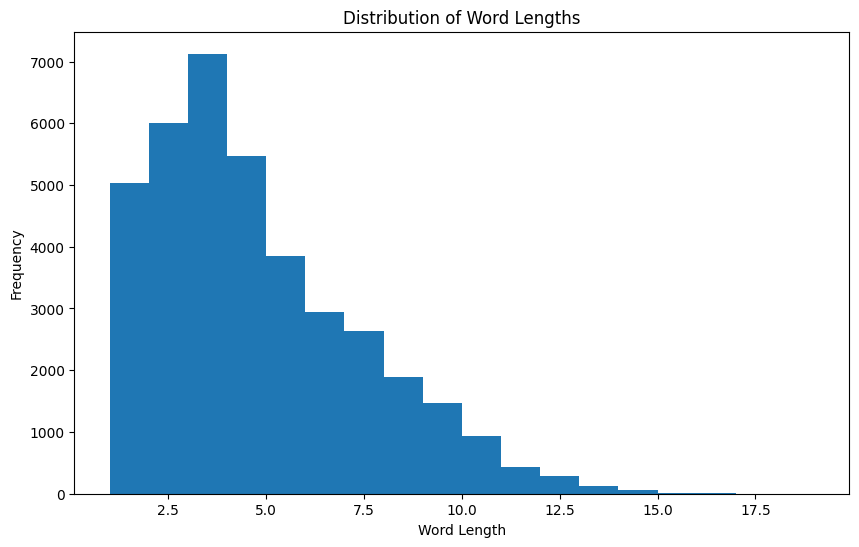

In [6]:
word_lengths = [len(word) for word in image_texts]
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=range(1, max(word_lengths) + 1))
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


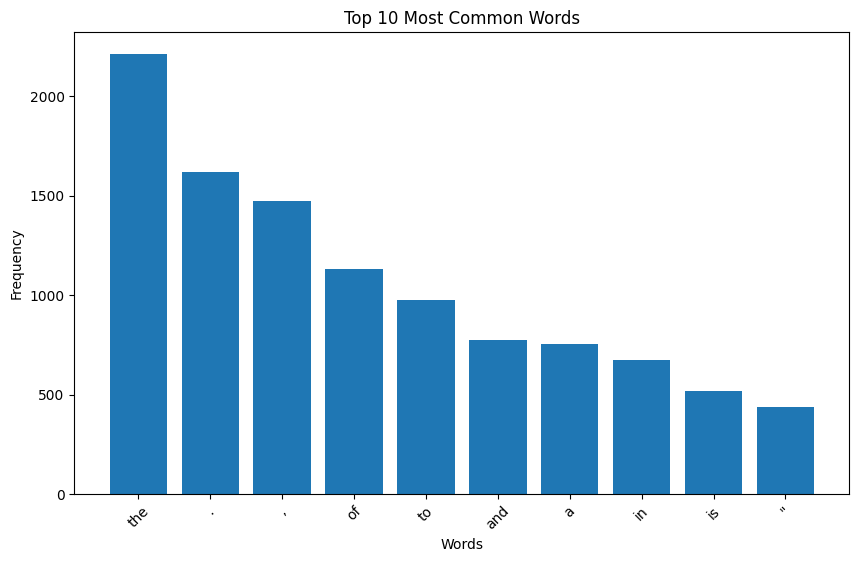

In [7]:
from collections import Counter
word_counts = Counter(image_texts)
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


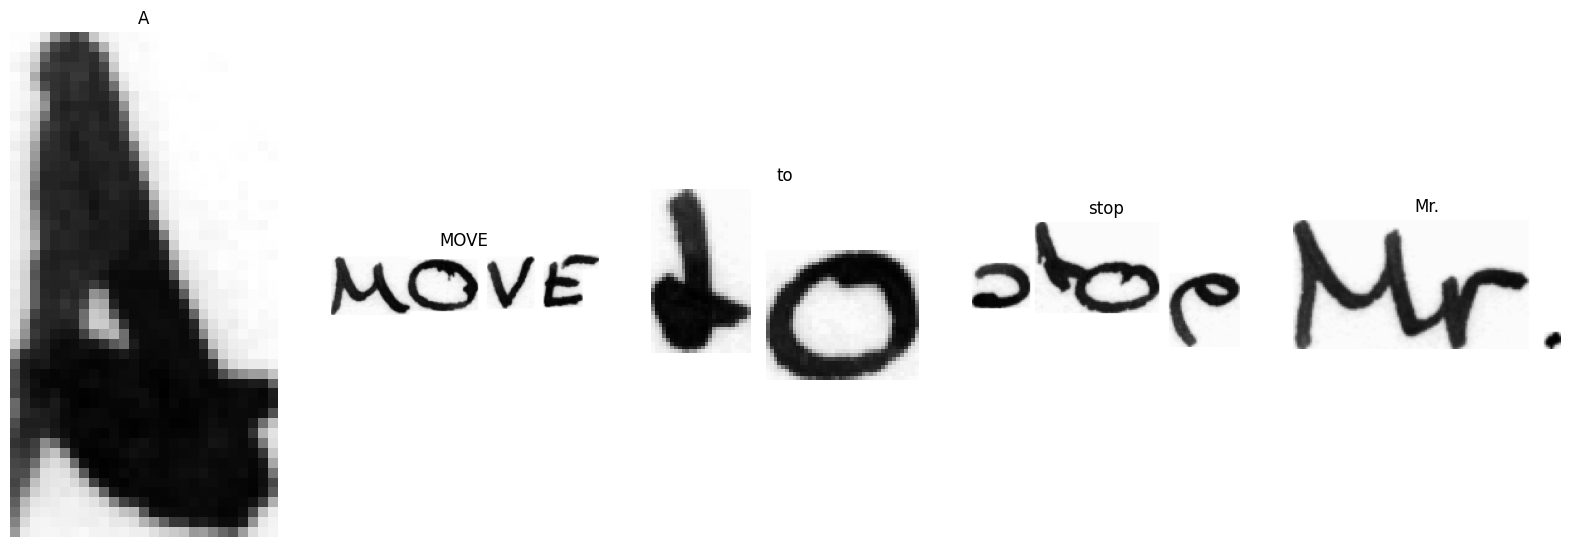

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for ax, (path, label) in zip(axes, zip(image_paths[:5], image_texts[:5])):
    image = plt.imread(path)
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.show()


The presence of ".", ",", "of", "to", "and", "a", "in", "is", "=", as the top words is indicative of common English language usage, particularly in written text where these words and symbols are frequently used for basic sentence structure and meaning.

The right-skewed distribution of word lengths suggests that while most words are relatively short, there's a long tail of longer words. This is typical of many natural language datasets, where a large number of unique words are used infrequently, contributing to a long tail in the distribution. For handwriting recognition, this implies that your model needs to handle a wide range of word lengths, from short to very long words, which can be challenging in terms of both recognizing the individual characters and understanding the spatial relationships between them in longer words.

In [9]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

corrupt_images, len(corrupt_images)

(['iam_words/words/a01\\a01-117\\a01-117-05-02.png'], 1)

In [10]:
for path in corrupt_images:
    
    corrupt_index = image_paths.index(path)
    del image_paths[corrupt_index]
    del image_texts[corrupt_index]
    

In [11]:

### get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:

max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

19

maximum label length among your images' text labels is 19 characters. This information is crucial for several reasons:

Model Input and Output: Knowing the maximum label length helps in defining the architecture of your neural network, especially the output dimensions of your model. For a handwriting recognition model, especially one based on a sequence-to-sequence framework like CTC (Connectionist Temporal Classification), you need to ensure that the model can handle sequences of this length.

Padding Sequences: When training your model, you'll likely need to pad the sequences to ensure that all of them have the same length. This is important for batching purposes, as deep learning models require inputs to be of a uniform size. Knowing the maximum label length allows you to apply the correct amount of padding to each sequence.

Performance Considerations: The maximum label length might also have implications for your model's performance. Longer sequences can be more challenging to predict accurately due to the increased possibilities for errors and the dependence on longer-term dependencies between characters. You might need to consider model architectures that are particularly good at capturing these dependencies, such as RNNs with LSTM or GRU layers.

In [13]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([24, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
       76, 76])

This step is essential for a few reasons:

Numerical Representation: Deep learning models work with numerical data, so converting your textual data into a numerical format is a necessary preprocessing step. Your choice of encoding each character to its index in a sorted list of all characters (char_list) is a common and effective approach.

Sequence Padding: By padding the sequences, you ensure that all your input data to the model has a uniform shape. This is crucial for batching and processing through your neural network layers, which require consistent input dimensions. You've chosen 'post' padding, which adds any necessary padding at the end of the sequences, ensuring that the beginning of each text (where the actual data is) aligns.

Handling Unknown Characters: Your try-except block within the encode_to_labels function is a good practice for handling characters that might not be present in your char_list. If you encounter such a character, your current setup will silently ignore it. Depending on your application, you might want to log these instances or add a special token to your char_list to represent unknown characters.

Preparation for Model Training: This encoding and padding process prepares your dataset for model training, specifically for models that rely on a fixed input size, such as Convolutional Neural Networks (CNNs) combined with Recurrent Neural Networks (RNNs) for sequence prediction tasks like handwriting recognition.



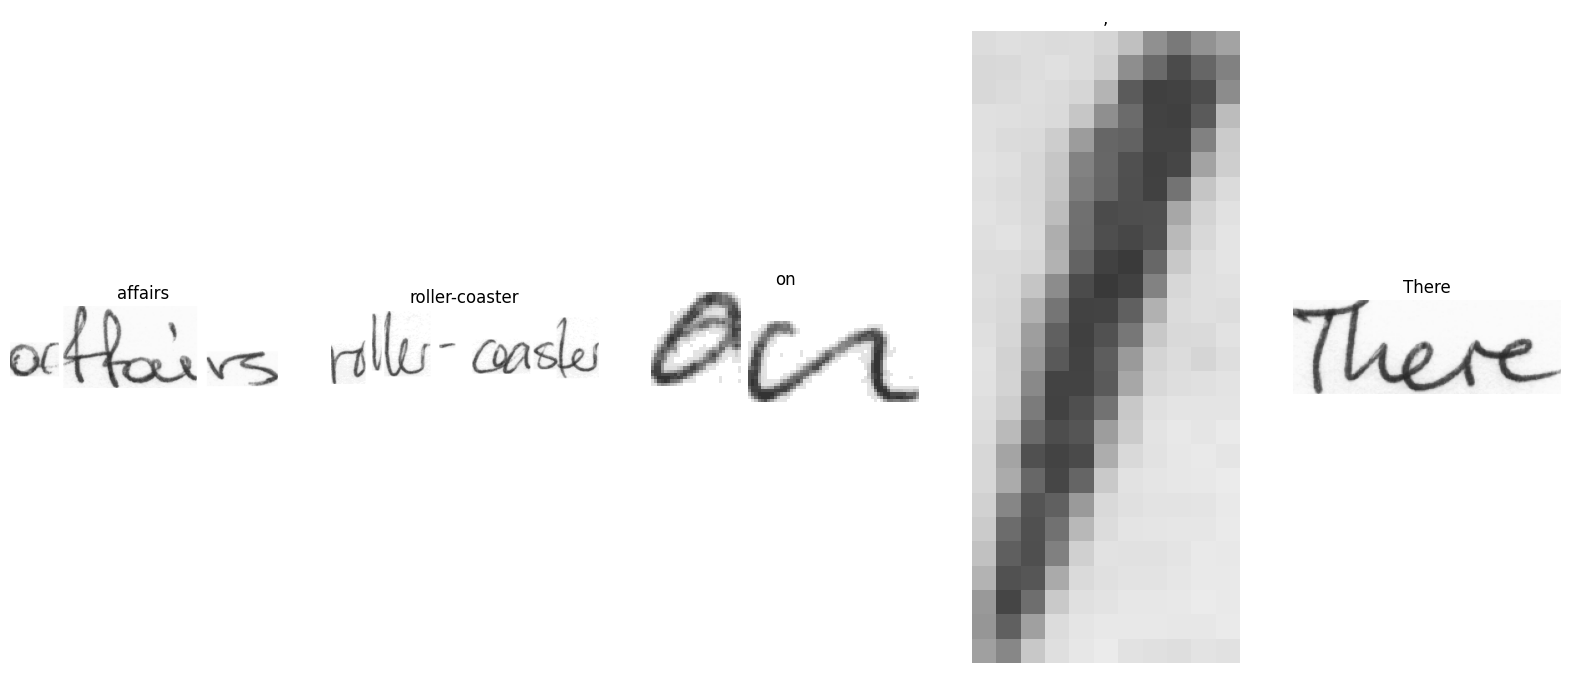

In [14]:
# Displaying a set of images with labels
def display_sample_images(image_paths, image_texts, sample_size=5):
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 10))
    for i in range(sample_size):
        img_path = np.random.choice(image_paths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = image_texts[image_paths.index(img_path)]
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Call the function
display_sample_images(image_paths, image_texts)


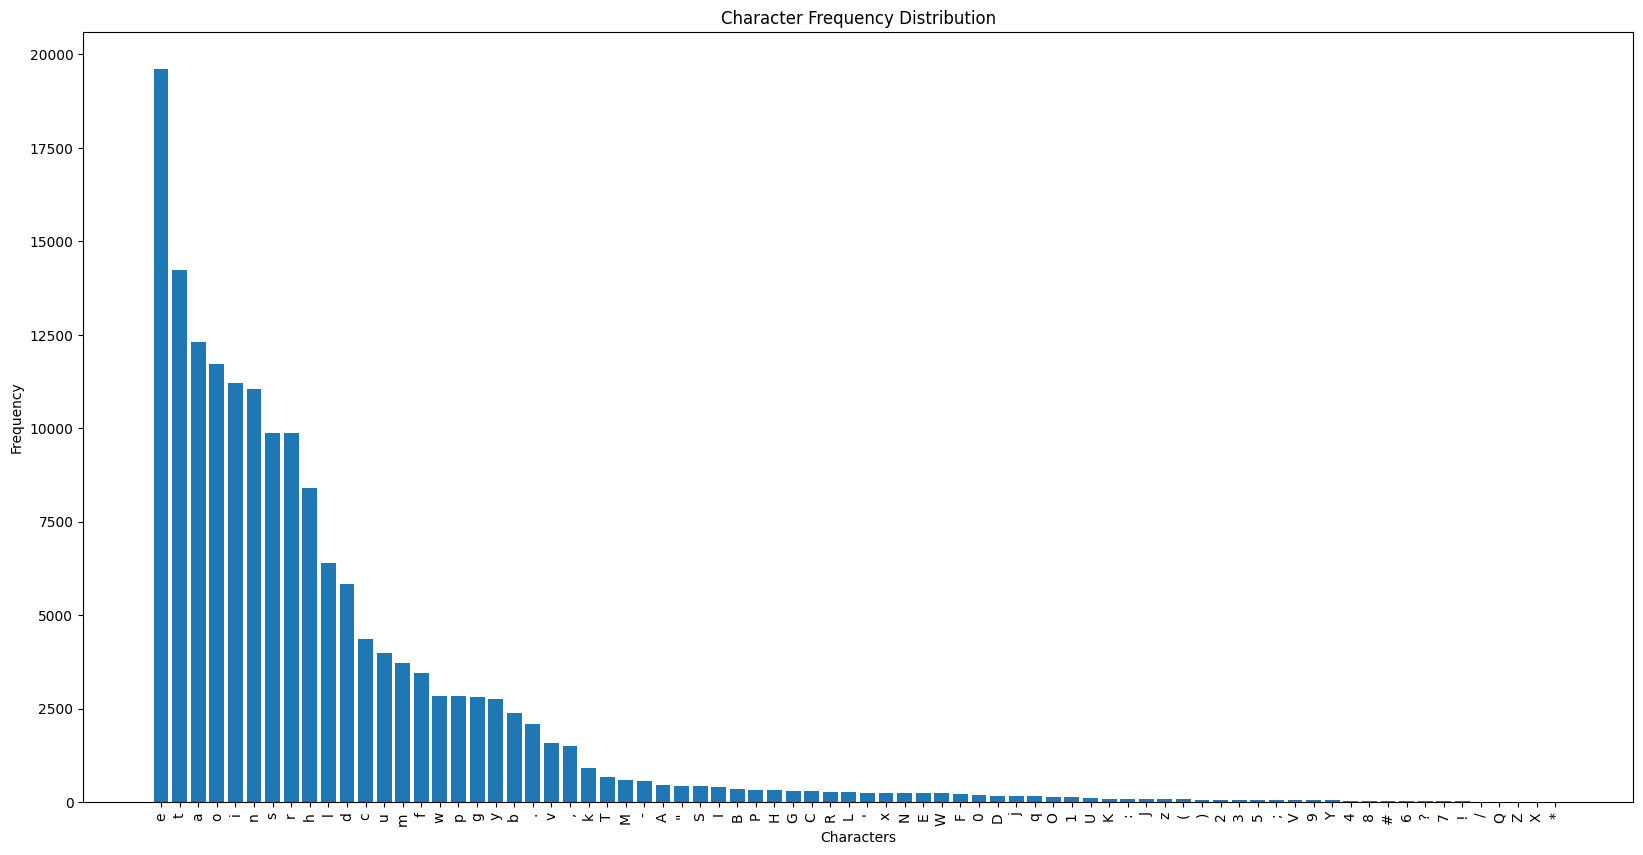

In [15]:
from collections import Counter

# Flatten the list of all characters in image_texts
all_chars = [char for text in image_texts for char in text]

# Calculate the frequency of each character
char_counter = Counter(all_chars)

# Sort characters by frequency
sorted_chars = sorted(char_counter.items(), key=lambda pair: pair[1], reverse=True)

# Plotting
plt.figure(figsize=(20, 10))
plt.bar([pair[0] for pair in sorted_chars], [pair[1] for pair in sorted_chars])
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency Distribution')
plt.xticks(rotation=90)
plt.show()


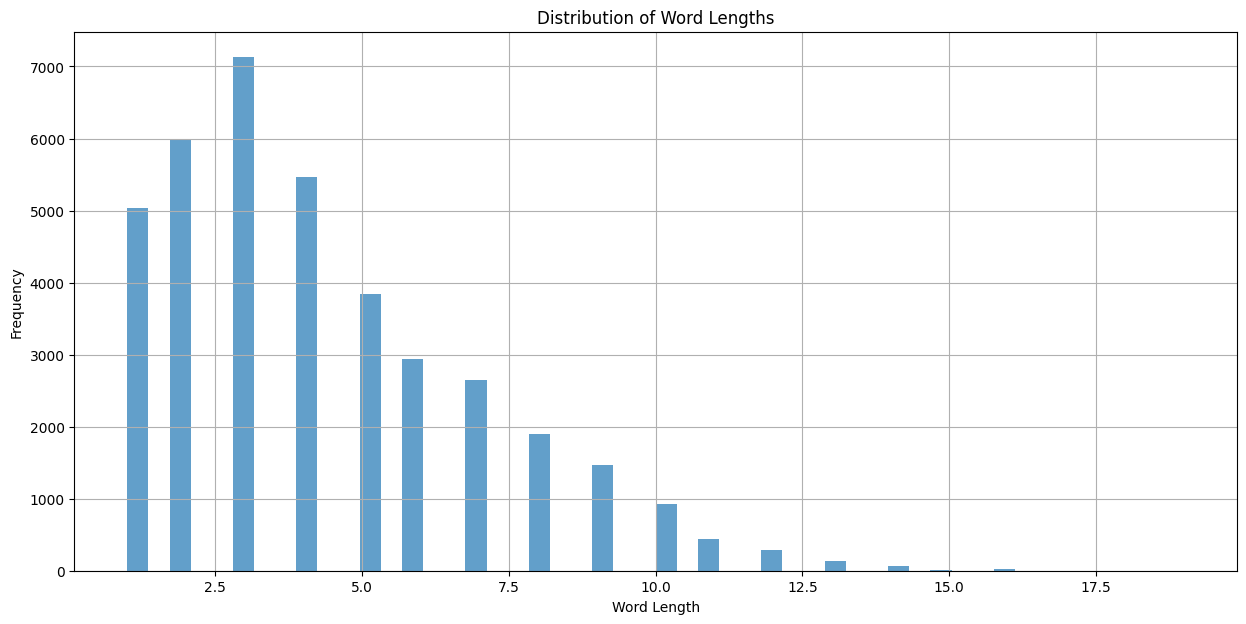

Word Lengths Statistics:
count    38304.000000
mean         4.302371
std          2.679291
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         19.000000
dtype: float64


In [16]:
word_lengths = [len(text) for text in image_texts]

# Plotting the distribution of word lengths
plt.figure(figsize=(15, 7))
plt.hist(word_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display basic statistics
print("Word Lengths Statistics:")
print(pd.Series(word_lengths).describe())


In [17]:
# Displaying the most and least common characters
print("Most common characters:")
print(sorted_chars[:10])  # Top 10

print("\nLeast common characters:")
print(sorted_chars[-10:])  # Bottom 10


Most common characters:
[('e', 19615), ('t', 14237), ('a', 12299), ('o', 11703), ('i', 11218), ('n', 11037), ('s', 9880), ('r', 9870), ('h', 8403), ('l', 6381)]

Least common characters:
[('#', 36), ('6', 28), ('?', 28), ('7', 24), ('!', 21), ('/', 9), ('Q', 6), ('Z', 5), ('X', 4), ('*', 3)]


In [18]:
# Re-checking for any corrupt images after the initial cleanup
recheck_corrupt_images = []

for path in image_paths:
    try:
        img = cv2.imread(path)
        if img is None:
            raise ValueError("Image not readable")
    except Exception as e:
        recheck_corrupt_images.append(path)

print(f"Found {len(recheck_corrupt_images)} corrupt images during re-check.")


Found 0 corrupt images during re-check.


## Observations:
1. Character Distribution: The most frequent characters are common English letters ('e', 't', 'a'), which is expected given the nature of English text. The least common characters include special symbols and less common letters ('Q', 'Z', 'X'), which might not be surprising but warrants attention when designing your model to ensure it can recognize these infrequent characters adequately.
2. Word Lengths: The average word length in your dataset is around 4 characters, with a standard deviation of approximately 2.68. This variability indicates that your model will need to handle a wide range of input lengths. The maximum word length is 19, which is crucial for defining the dimensions of your model's input layer or for padding sequences.
3. Class Imbalance: There's a significant imbalance between the most and least common characters. This imbalance can lead to a model that performs well on frequent characters but struggles with rare characters or symbols.


### Approach to Address Class Imbalance
One effective strategy is to use a weighted loss function during training, where less frequent classes (characters) are given higher weights, encouraging the model to pay more attention to these classes. This section will outline how to calculate class weights and apply them in a training loop, assuming a hypothetical neural network model setup for context.

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming 'char_list' is a list of all characters, and 'image_texts' contains all the words in the dataset
all_chars = ''.join(image_texts)
char_freq = {char: all_chars.count(char) for char in char_list}

# Create a list of all characters in the dataset in the same order as 'char_list'
y = np.array([char for word in image_texts for char in word])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight_dict)


{0: 103.25689223057644, 1: 4.939395755904568, 2: 60.23318713450293, 3: 8.570730185146662, 4: 30.977067669172932, 5: 33.8811677631579, 6: 722.7982456140351, 7: 1.4360230045311955, 8: 3.8446715192235907, 9: 1.0424974696356275, 10: 240.9327485380117, 11: 11.472988025619605, 12: 15.488533834586466, 13: 34.41896407685881, 14: 37.38611615245009, 15: 58.60526315789474, 16: 38.04201292705448, 17: 77.44266917293233, 18: 90.34978070175438, 19: 60.23318713450293, 20: 44.25295381310419, 21: 28.911929824561405, 22: 42.51754385964912, 23: 77.44266917293233, 24: 4.683357962941912, 25: 6.2131654350776655, 26: 7.45152830529933, 27: 13.468290290944752, 28: 8.997488534614545, 29: 10.180256980479367, 30: 7.227982456140351, 31: 6.949983130904184, 32: 5.503539941223617, 33: 29.30263157894737, 34: 24.924077434966726, 35: 8.121328602404889, 36: 3.700332315430214, 37: 8.960308829926054, 38: 15.378686076894363, 39: 6.927778711955608, 40: 361.39912280701753, 41: 7.972039473684211, 42: 4.939395755904568, 43: 3.30